# Helper


In [26]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

In [27]:
csv_dir = "../output/"

In [28]:
def parse_boundary(csv_path):
    data = pd.read_csv(csv_path, header=None)
    x, y, z = data[0], data[1], data[2]
    # x, y = (x + 1) / 2, (y + 1) / 2
    return x, y, z

In [29]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

def parse_csv_for_xy(path):
    # Read CSV assuming pairs of x, y coordinates (x1, y1, x2, y2, ...)
    data = pd.read_csv(path, header=None)
    
    # Convert all values to numeric, forcing errors to NaN (which makes them easier to handle)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Flatten the data into x and y arrays
    x_vals = data.iloc[:, 0::2].values.flatten()  # Extract x values (every other column starting from 0)
    y_vals = data.iloc[:, 1::2].values.flatten()  # Extract y values (every other column starting from 1)

    return x_vals, y_vals

def get_original_points(s = 16):
    x = []
    y = []
    for j in range(s):
        for i in range(s):
            x.append((i / (s - 1)) * 2 - 1)
            y.append((j / (s - 1)) * 2 - 1)
    x = np.array(x)
    y = np.array(y)
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    return x, y
        

def visualize_csv_output_vector(path, path2=None, output_path="./solver_output_plot.png", original_point=None, xstart=0, ystart=0, xend=1, yend=1, surface=False):
    # Parse CSV to get x, y values
    x_vals, y_vals = parse_csv_for_xy(path)
    
    # Remove NaN values from the data
    valid_mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)  # Create mask for non-NaN values in x and y
    x_vals = x_vals[valid_mask]  
    y_vals = y_vals[valid_mask] 
    
    # If a second CSV is provided, parse it and append the x, y values
    x_vals2, y_vals2 = None, None
    if path2:
        x_vals2, y_vals2 = parse_csv_for_xy(path2) 
    
    assert len(x_vals) == len(y_vals), "x_vals and y_vals must have the same length"
    z_vals = np.zeros_like(x_vals)

    # Create a figure for plotting
    fig = go.Figure()

    # Add surface plot with interpolated Z values (if surface is true)
    if surface: 
        x = np.linspace(xstart, xend, 100)  # Increase resolution if necessary
        y = np.linspace(ystart, yend, 100)  # Increase resolution if necessary
        X, Y = np.meshgrid(x, y)
        
        # Interpolate the Z values onto the grid (if you want smooth surface interpolation)
        Z_interp = griddata((x_vals, y_vals), z_vals, (X, Y), method='linear')
        fig.add_trace(go.Surface(z=Z_interp, x=X, y=Y, colorscale='Viridis', showscale=True))

    # Add a scatter plot for the original points (if surface is false)
    if not surface:
        fig.add_trace(go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers',
            marker=dict(size=2, color='blue') 
        ))
        if path2: 
            fig.add_trace(go.Scatter3d(x=x_vals2, y=y_vals2, z=z_vals, mode='markers',
                marker=dict(size=2, color='red') 
            ))
        
    
    # Add boundary if provided
    if original_point: 
        x_original, y_original = get_original_points()
        z_original = np.zeros_like(x_original) - 0.001
        fig.add_trace(go.Scatter3d(x=x_original, y=y_original, z=z_original, mode='markers',
            marker=dict(size=2, color='red')  
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        zaxis=dict(
            range=[-0.01, 0.01]  # Set the Z-axis range (adjust these values as needed)
        ),
        aspectmode='cube'  # Ensures that all axes are scaled equally
    ))

    # Show the plot and save to file
    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")
    
def visualize_csv_output_x(path, output_path="./solver_output_plot.png", original_point=False, xstart=0, ystart=0, xend=1, yend=1):
    data = pd.read_csv(path, header=None)
    x = np.linspace(xstart, xend, data.shape[1])
    y = np.linspace(ystart, yend, data.shape[0])
    X, Y = np.meshgrid(x, y)
    solved_X = data.values         

    # Create a mask for valid points
    valid_mask = ~np.isnan(solved_X)

    # Filter X, Y, Z using the mask
    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    solved_X_valid = solved_X[valid_mask]

    # Create a scatter plot for valid points
    fig = go.Figure()

    # Add a scatter plot for the valid points
    Z = np.zeros_like(solved_X_valid)
    fig.add_trace(go.Scatter3d(x=solved_X_valid, y=Y_valid, z=Z, mode='markers',
            marker=dict(size=2, color='blue')  # Customize marker appearance if needed
    ))
    
    if original_point: 
        x_original, y_original = get_original_points()
        z_original = np.zeros_like(x_original) - 0.001
        fig.add_trace(go.Scatter3d(x=x_original, y=y_original, z=z_original, mode='markers',
            marker=dict(size=2, color='red')  
        ))

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ))

    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")


In [30]:
import plotly.graph_objects as go
def print_boundary_dirichlet(path=None, shape=None, dir=None): 
    if path is None: path = dir + shape + 'BoundaryDirichlet.csv'
    x, y, z = parse_boundary(path)
    fig = go.Figure()
    for i in range(len(x)):
        fig.add_trace(go.Scatter3d(
            x=[x[i], x[(i + 1) % len(x)]],
            y=[y[i], y[(i + 1) % len(y)]],
            z=[z[i], z[(i + 1) % len(z)]],
            mode='lines',
            line=dict(color='blue', width=2)
        ))
    fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',
        marker=dict(size=5, color='red', opacity=0.8)  # Color points
    ))

    fig.update_layout(title_text='3D Star Shape on a Tilted Plane',
                  scene=dict(
                      xaxis_title='X-axis',
                      yaxis_title='Y-axis',
                      zaxis_title='Z-axis'),
                  )

    fig.show()

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
def visualize_strain_norm_2D(coordinates, gradient_norms, only_show_highest=False):
    coordinates = np.array(coordinates)
    x = coordinates[:, 0]  
    y = coordinates[:, 1]  
    print(x[3],y[3],gradient_norms[3])
    
    # Min and Max values for setting the grid limits
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Create the mesh grid for visualization
    grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    print(gradient_norms.shape)
    
    # if print highest, set all other values to 0
    if only_show_highest: 
        max_index = np.argmax(gradient_norms)
        gradient_norms = np.zeros_like(gradient_norms)
        gradient_norms[max_index] = 1
    
    # Use linear interpolation to get smoother transitions
    grid_values = griddata((x, y), gradient_norms, (grid_x, grid_y), method='linear')
    
    # Normalize the color scale to improve visibility of small differences
    norm = Normalize(vmin=np.min(gradient_norms), vmax=np.max(gradient_norms))
    
    # Plotting the 2D strain norm visualization
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(grid_x, grid_y, grid_values, levels=100, cmap='viridis', norm=norm)
    plt.colorbar(contour, label='Strain Norm')
    
    # Scatter plot of the coordinates with their strain norms
    plt.scatter(x, y, c=gradient_norms, cmap='viridis', edgecolors='k', s=100, marker='o', label='Coordinates', norm=norm)
    
    # Labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Strain Norms Visualization')
    plt.legend()
    plt.show() 

In [36]:
import pandas as pd
def visualize_stress(path, only_show_highest=False):
    # data is organized as follows: X, Y, Eigenvalue
    data = pd.read_csv(path, header=None)
    x = data[0]
    y = data[1]
    coordinates = np.array([x, y]).T
    e = data[2]
    
    visualize_strain_norm_2D(coordinates, e, only_show_highest)
    

## file utilities

In [21]:
def get_shape_csv(shape): 
    return "" + shape + ".csv"
def get_displacement_csv(shape):
    return "" + shape + "_displacements.csv"
def get_boundaryD_csv(shape): 
    return "" + shape + "BoundaryDirichlet.csv"
def get_eigenvalue_csv(shape, addedNumber=''):
    return "" + shape + "_eigenvalues" + addedNumber + ".csv"

# Code


## Displacements

In [25]:
shape = "trousers"
shape_csv = get_shape_csv(shape)
displacement_csv = get_displacement_csv(shape)
boundary_csv = get_boundaryD_csv(shape)

In [30]:
visualize_csv_output_vector(csv_dir + displacement_csv, original_point=False) 

Figure saved as ./solver_output_plot.png


In [28]:
visualize_csv_output_vector(csv_dir + shape_csv, original_point=False) 

Figure saved as ./solver_output_plot.png


In [32]:
visualize_csv_output_vector(csv_dir + shape_csv, csv_dir + displacement_csv, original_point=False)

Figure saved as ./solver_output_plot.png


## Eigvals 

In [23]:
eig_csv = get_eigenvalue_csv(shape)
eig_csv2 = get_eigenvalue_csv(shape, '2')
eig_csv3 = get_eigenvalue_csv(shape, '3')

0.266667 0.0666667 1.25368
(190,)


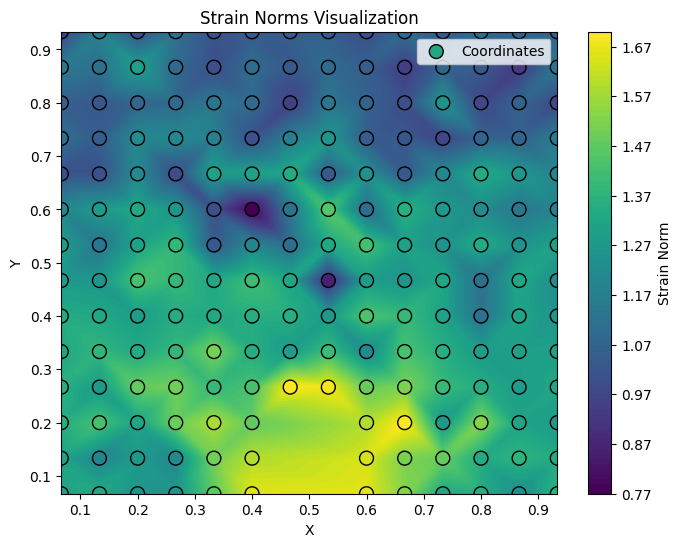

In [33]:
visualize_stress(csv_dir + eig_csv)

0.266667 0.0666667 1.25368
(190,)


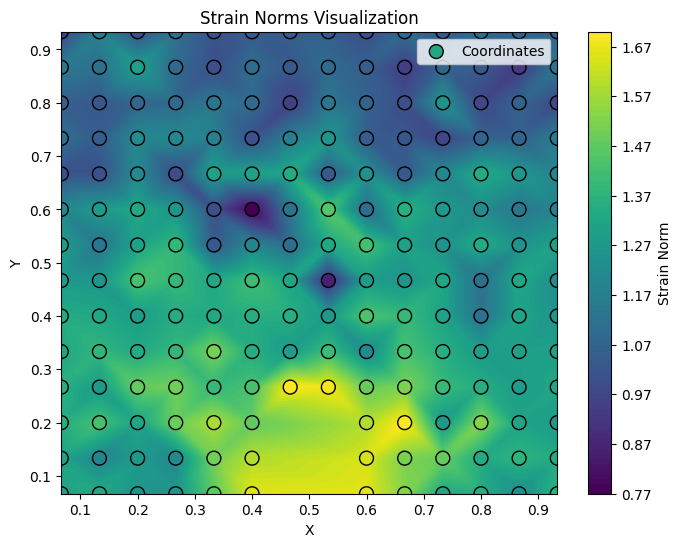

In [34]:
visualize_stress(csv_dir + eig_csv2)

0.266667 0.0666667 1.64977
(190,)


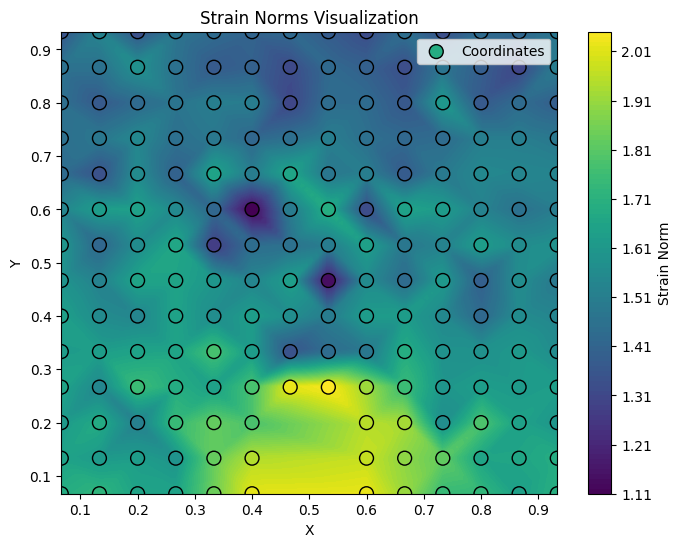

In [35]:
visualize_stress(csv_dir + eig_csv3)

0.266667 0.0666667 1.25368
(190,)


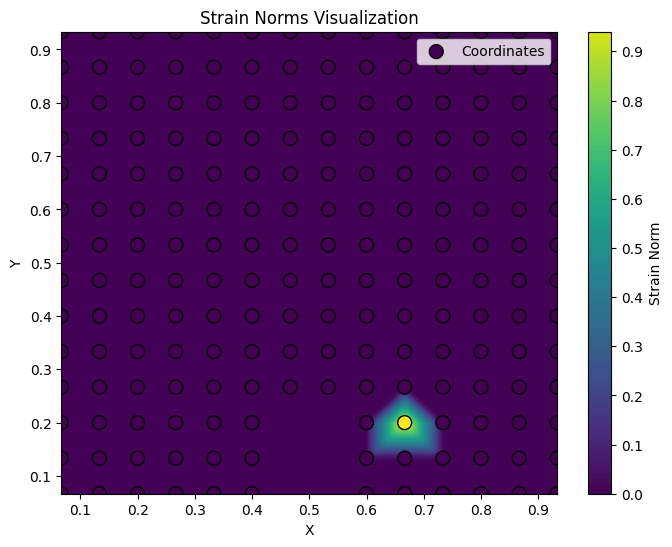

0.266667 0.0666667 1.25368
(190,)


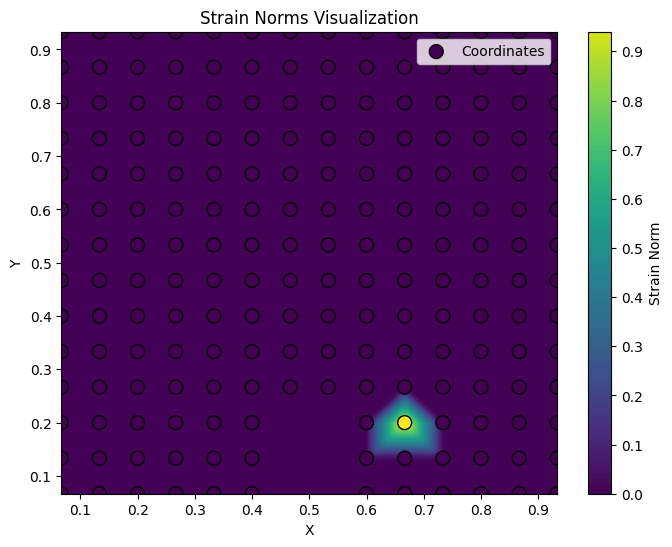

0.266667 0.0666667 1.64977
(190,)


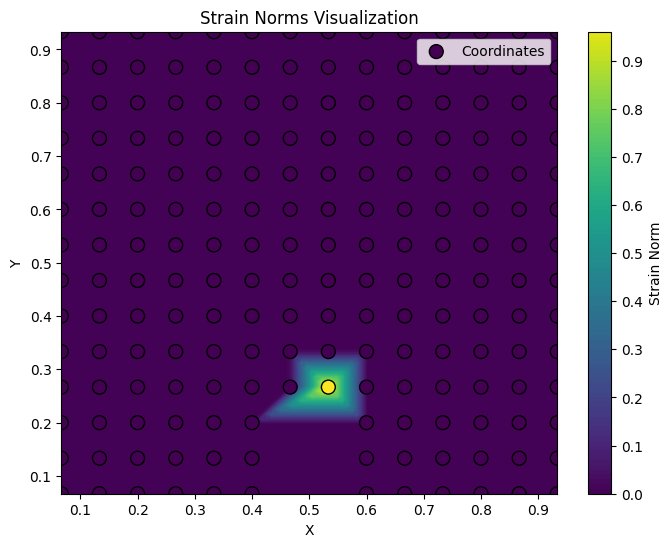

In [40]:
visualize_stress(csv_dir + eig_csv, only_show_highest=True)
visualize_stress(csv_dir + eig_csv2, only_show_highest=True)
visualize_stress(csv_dir + eig_csv3, only_show_highest=True)